In this notebook I have demonstrated:
* EDA: RSNA 2024 Lumbar Spine Degenerative dataset
* Result of Unet inference model

# 📒 Notebooks
📌 **UNet**:
* EDA: [EDA: Lumbar Spine Segmentation](https://www.kaggle.com/code/tabassumnova/eda-lumbar-spine-segmentation)
* Train: [Spine Segmentation: Unet training](https://www.kaggle.com/code/tabassumnova/spine-segmentation-unet-training)
* Infer: [Spine Segmentation: Unet Inference](https://www.kaggle.com/code/tabassumnova/spine-segmentation-unet-inference)

📌 **Segmentation Dataset**:
* [Lumbar-Spine-Segmentation](https://www.kaggle.com/datasets/tabassumnova/lumbar-spine-segmentation)


# EDA

In [1]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import sys
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
# read data
train_path = '/home/nova/Desktop/Nova/Segmentations/rsna-2024-lumbar-spine-degenerative-classification/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [3]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_desc, f'{train_path}/train_images')
# test_image_paths = generate_image_paths(test_desc, f'{train_path}/test_images')

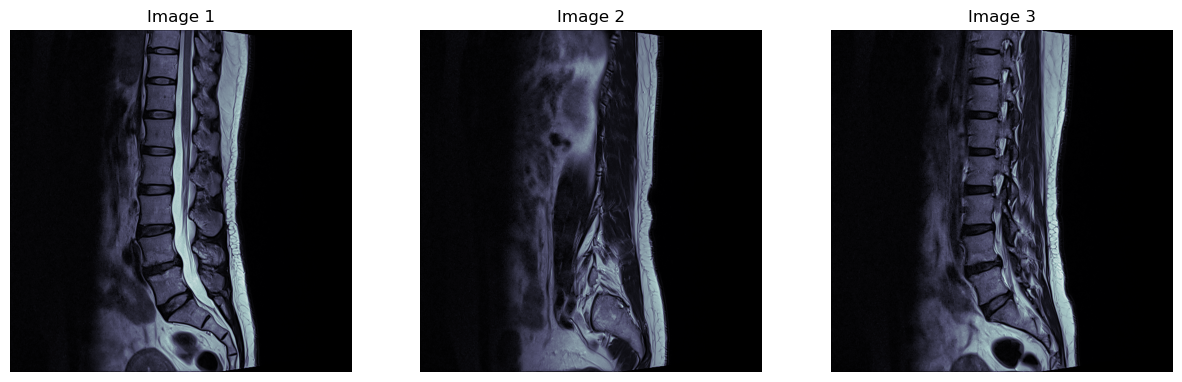

In [4]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths)

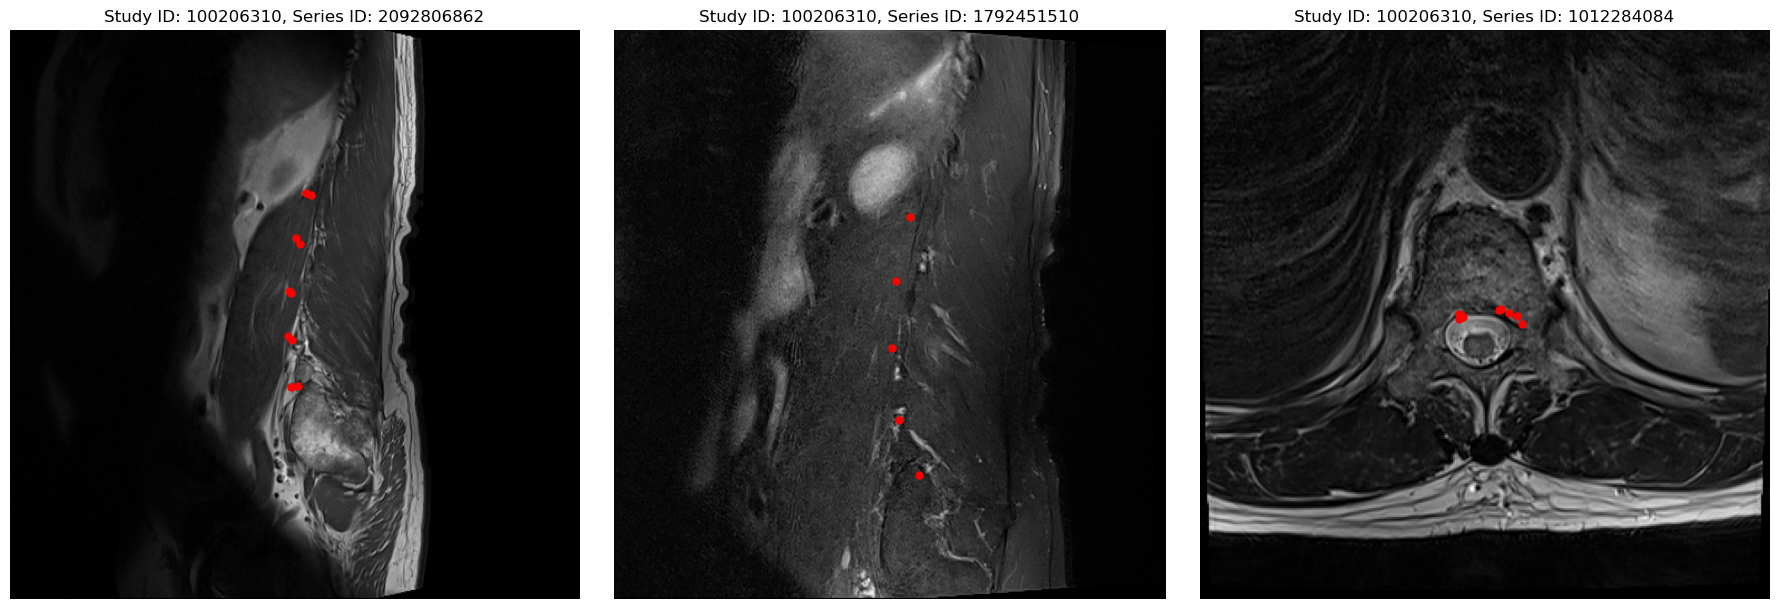

In [5]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Function to open and display DICOM images along with coordinates
def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))
    
    for idx, path in enumerate(image_paths):  # Display images
        study_id = int(path.split('/')[-3])
        series_id = int(path.split('/')[-2])
        
        # Filter label coordinates for the current study and series
        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]
        
        # Read DICOM image
        ds = pydicom.dcmread(path)
        
        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')
        
        # Plot coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)
        
    plt.tight_layout()
    plt.show()

# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# Display DICOM images with coordinates
study_id = "100206310"
study_folder = f'{train_path}/train_images/{study_id}'

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])  # Add the first image from each series


display_dicom_with_coordinates(image_paths, label)

# Data Preprocessing

In [6]:
# Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(5)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [7]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [8]:
# Merge the dataframes on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [9]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [10]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}/train_images/' + 
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/home/nova/Desktop/Nova/Segmentations/rsna-202...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/home/nova/Desktop/Nova/Segmentations/rsna-202...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/home/nova/Desktop/Nova/Segmentations/rsna-202...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/home/nova/Desktop/Nova/Segmentations/rsna-202...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/home/nova/Desktop/Nova/Segmentations/rsna-202...


In [11]:
# Define the base path for test images
base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

""


In [12]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [13]:
test_data = expanded_test_desc
train_data = final_merged_df

In [14]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [15]:
train_data.head(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/home/nova/Desktop/Nova/Segmentations/rsna-202...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/home/nova/Desktop/Nova/Segmentations/rsna-202...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/home/nova/Desktop/Nova/Segmentations/rsna-202...,True,True,True


In [37]:
cwd = os.getcwd()
path = cwd + "/train_data.csv"
train_data.to_csv(path)

In [16]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

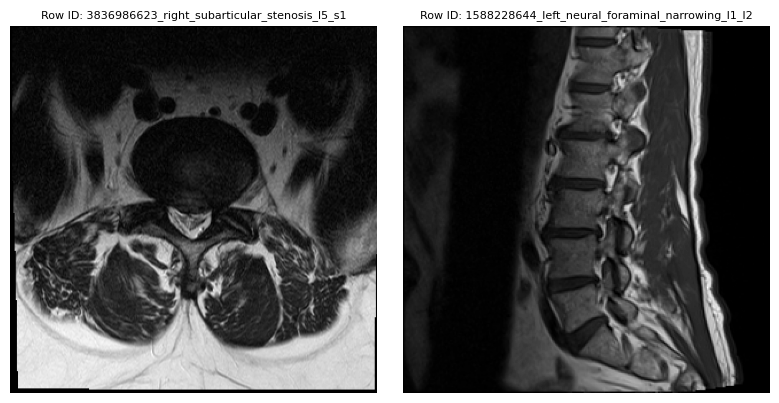

In [17]:
# Load images randomly
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# References
I took most of the inspiration from the following notebooks
- https://www.kaggle.com/code/shubhamcodez/rsna-efficientnet-starter-notebook
- https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/
- https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/
- https://www.kaggle.com/code/anoukstein/2d-segmentation-of-sagittal-lumbar-spine-mri